# CSTR Model

This notebook aims to replicate the CSTR model created by Pilario & Cao (2018) which can be found [here](https://dspace.lib.cranfield.ac.uk/bitstream/handle/1826/13055/Canonical_variate_dissimilarity_analysis-2018.pdf?sequence=4). Check the pdf in the docs folder for more details. 

## Baseline Model

Recreating the model exactly for normal operation and comparing results. 

In [2]:
from tools import PID
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
        
def cstr_model(t,y):
    
    C, T, T_c = y

    k = k_0*np.exp(-E_a/(R*T))
    
    Q_c=pid(T,t)
    
    dC_dt = (Q/V)*(C_i-C) - k*C
    dT_dt = (Q/V)*(T_i-T) - H_r*k*C/(rho*C_p) - UA*(T-T_c)/(rho*C_p*V)
    dTc_dt = (Q_c/V_c)*(T_ci - T_c) + UA * (T-T_c)/(rho_c*C_pc*V_c)
    
    return dC_dt, dT_dt, dTc_dt


def plot_results(t, sol, pid):
    C = sol[0]
    T = sol[1]
    T_c = sol[2]

    plt.subplots(2,2,figsize=(10,10))
    
    it = 1
    for item,title,ylabel in zip([C, T, T_c],['Reactant','Reactor Temperature','Cooling Jacket Temperature'],['C [mol/L]','T [K]','$T_c$ [K]']):
        plt.subplot(2,2,it)
        plt.plot(t,item)
        plt.ylabel(ylabel)
        plt.xlabel('t [min]')
        plt.title(title)
        plt.grid()
        it+=1
        
    plt.subplot(2,2,4)
    pid.plot_results()
    plt.ylim([0,210])
    plt.grid()
    plt.ylabel('$Q_c [L/min]$')
    plt.xlabel('t [min]')
    plt.title('Cooling Water Flow rate')
    
    print("Results at final time step are: ", [round(item,2) for item in sol[:,-1]]+[pid.store[-1][1]])

ModuleNotFoundError: No module named 'matplotlib'

In [68]:
from pathlib import Path

# Reactor constants
V = 150  # L
V_c =10 #    L
UA = 7E5#      cal/min/K
Q=100# L/min

# Reaction constants
E_a  = 83140#   J/mol 
R  = 8.314 #    J/K/mol 
H_r  =-2E5 #       cal/mol 
k_0  =7.2E10 #      1/min 

# Fluid constants
C_p = 1 # cal/g/k
C_pc  =1 #   cal/g/k 
rho = 1000 # g/L
rho_c = 1000 #g/l

path = Path('docs/img/')

Results at final time step are:  [0.1, 430.0, 416.39, 147.0111831451884]


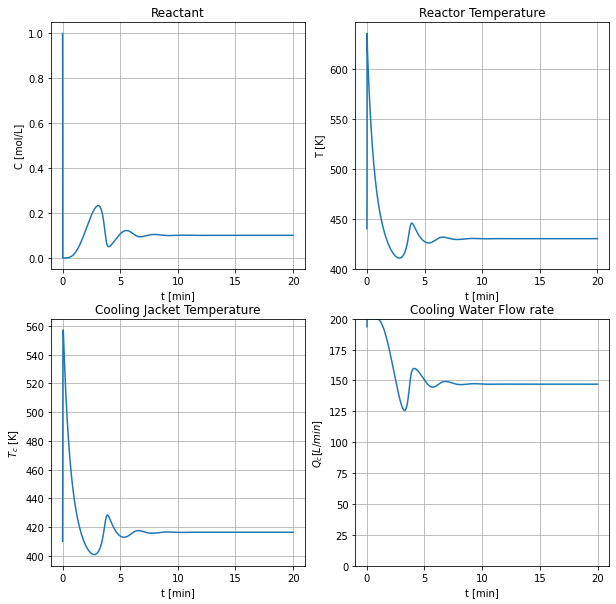

In [69]:
pid=PID(K_p=-1,tau_i=-0.5,setpoint=430,u_bias=150,limits=(20,200), sample_dt=0.01)

C_i, T_i, T_ci = [0.97, 351.5, 351.6]
y0 = [1, 440, 410]
res = solve_ivp(cstr_model,(0,20),y0, method='RK45',max_step=0.01)


# Plot results
plot_results(res.t, res.y, pid)
plt.savefig(path/'baseline_model_results.png',dpi=100)


In [61]:
import pandas as pd

store = []
for ini_cond in [[0.97, 351.5, 351.6],[0.97, 352.1, 349.8],[0.97, 351.2, 348.3],[0.93, 348.3, 349.8]]:


    pid=PID(K_p=-1,tau_i=-0.5,setpoint=430,u_bias=150,limits=(20,200), sample_dt=0.01)

    C_i, T_i, T_ci = ini_cond
    y0 = [1, 440, 410]
    res = solve_ivp(cstr_model,(0,20),y0, method='RK45',max_step=0.01)
    
    sol = [round(item,2) for item in res.y[:,-1]] + [round(pid.store[-1][-1],2)]
    store.append(sol)
    
store = pd.DataFrame(store,columns = ['C','T','$T_c$','$Q_c$'],index=['0 mins','60 mins', '120 mins', '180 mins'])
store

,C,T,$T_c$,$Q_c$
0 mins,0.1,430.0,416.39,147.01
60 mins,0.1,430.0,416.31,144.12
120 mins,0.1,430.0,416.44,139.36
180 mins,0.1,430.0,417.87,124.70


In [63]:
print(store.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &    C &      T &   \$T\_c\$ &   \$Q\_c\$ \\
\midrule
0 mins   &  0.1 &  430.0 &  416.39 &  147.01 \\
60 mins  &  0.1 &  430.0 &  416.31 &  144.12 \\
120 mins &  0.1 &  430.0 &  416.44 &  139.36 \\
180 mins &  0.1 &  430.0 &  417.87 &  124.70 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10022/1877560755.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(store.to_latex())


## Dataset Generation: Substandard Operation (sample)

Model for the generation of substandard operation. Just simulating for 1200 minutes.

In [176]:

def perturb_inputs(t):
    """
    Function to change inlet conditions
    """
    
    variant = int(t/change_dt)
    
    return C_i_list[variant], T_i_list[variant], T_ci_list[variant] 
        
def cstr_model_real(t,y):
    """
    CSTR model that emulates real data
    """
    
    # Unpack variables
    C, T, T_c = y
    
    # Inlet conditions are sampled from a uniform distribution
    C_i, T_i, T_ci = perturb_inputs(t)
    
    # Catalyst degradation and jacket fouling
    alpha = 1-0.1*t/T_max
    beta = 1-0.1*t/T_max
    beta=1

    # Flowrate is adjusted automatically by PID controller
    Q_c=pid(T,t)

    # Reaction rate is determined by Arrhenius equation
    k = k_0*np.exp(-E_a/(R*T))
    
    # Noise in differential equations
    G_C = np.random.normal(scale=0.01)
    G_T = np.random.normal(scale=0.1)
    
    # Differential equations
    dC_dt = (Q/V)*(C_i-C) - alpha*k*C + G_C
    dT_dt = (Q/V)*(T_i-T) - H_r*k*C/(rho*C_p) - beta*UA*(T-T_c)/(rho*C_p*V)+ G_T
    dTc_dt = (Q_c/V_c)*(T_ci - T_c) + UA * (T-T_c)/(rho_c*C_pc*V_c) + G_T
    
    return dC_dt, dT_dt, dTc_dt



Results at final time step are:  [0.11, 429.94, 415.2, 157.19023358516645]


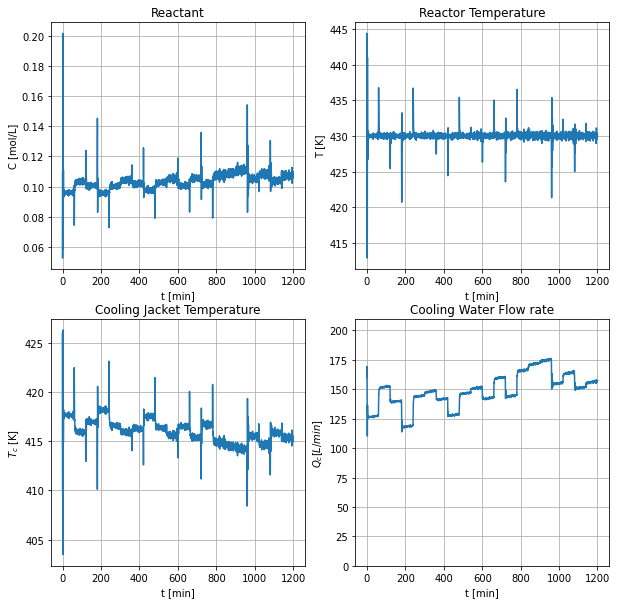

In [177]:
# Define the input parameters and PID controller
t_span = (0, 1200) # Start and end time
pid=PID(K_p=-1,tau_i=-0.5,setpoint=430,u_bias=150,limits=(20,200), sample_dt=0.01)
change_dt = 60 # How often inputs change
T_max = 1200 # time when there is a 10% reduction in catalyst and jacket 


# Define perturbed inputs (change every change_dt minutes)
size = int(t_span[1]/60)+1
C_i_list = np.random.uniform(size=size,low=0.9, high=1.0)
T_i_list = np.random.uniform(size=size,low=348, high=352)
T_ci_list = np.random.uniform(size=size,low=348, high=352)

# Solve equations
t_eval = np.linspace(t_span[0],t_span[1],num=int((t_span[1])*100))
y0 = [0.11, 440, 410]
res = solve_ivp(cstr_model_real,t_span,y0, method='RK45',max_step=0.01,t_eval=t_eval)

plot_results(res.t, res.y, pid)
plt.savefig(path/"dataset_substandard.png", dpi=100)

In [195]:
import pandas as pd

# Capture all results in dataframe for easy analysis

# Dynamic variables
C = res.y[0]
T = res.y[1]
T_c = res.y[2]
t=res.t
tmp = pd.DataFrame([C,T,T_c],).T
tmp.columns = ['C','T','T_c']
tmp.index=t

# Inlet variables
tmp_2 = pd.DataFrame([C_i_list,T_i_list, T_ci_list]).T
tmp_2.index=np.linspace(t_span[0],t_span[1],size)
tmp_2.columns=['C_i','T_i','T_ci']
tmp_2 = tmp_2.reindex(t_eval,method='ffill')

# PID
x = [0]+[item[0] for item in pid.store]
y = [150]+[item[1] for item in pid.store]
tmp_3 = pd.Series(y,index=x,name='Q_c').reindex(t_eval,method='ffill')

# Concat
results = pd.concat([tmp,tmp_2,tmp_3],axis=1)
results



,C,T,T_c,C_i,T_i,T_ci,Q_c
0.00,0.110000,440.000000,410.000000,0.916760,351.918247,349.470391,150.000000
0.01,0.104827,440.320282,418.005729,0.916760,351.918247,349.470391,160.396732
0.02,0.100029,440.805093,421.226171,0.916760,351.918247,349.470391,161.169071
0.03,0.095450,441.330230,422.801469,0.916760,351.918247,349.470391,161.169071
0.04,0.091100,441.843341,423.667165,0.916760,351.918247,349.470391,162.128285
...,...,...,...,...,...,...,...
1199.96,0.106829,429.977434,415.226760,0.939198,348.517068,349.508644,157.239886
1199.97,0.107029,429.967346,415.219014,0.939198,348.517068,349.508644,157.220343
1199.98,0.106989,429.959362,415.212431,0.939198,348.517068,349.508644,157.208389
1199.99,0.106916,429.948800,415.205340,0.939198,348.517068,349.508644,157.208389


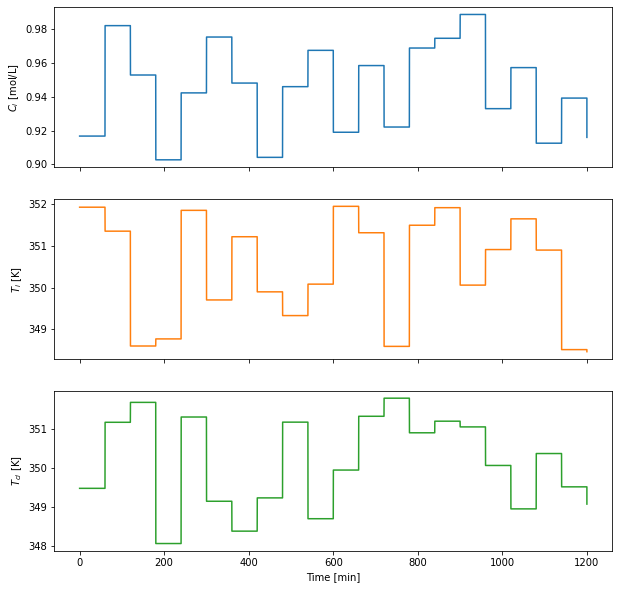

In [196]:
axes = results[['C_i','T_i','T_ci']].plot(subplots=True,figsize=(10,10),xlabel='Time [min]',legend=False)
axes[0].set_ylabel('$C_i$ [mol/L]')
axes[1].set_ylabel('$T_i$ [K]')
axes[2].set_ylabel('$T_{ci}$ [K]')

plt.savefig(path/"dataset_substandard_inlet.png", dpi=100)

In [197]:
# Sensor drift: Shift T and C_i by a certain amount
results['T'] = results['T']+2
results['C_i']=results['C_i']+0.1

# Gaussian noise
for item in results.columns:
    mean_val = results[item].mean()
    results[item]=results[item]+np.random.normal(size=(len(results)),scale=0.001*mean_val)


results

,C,T,T_c,C_i,T_i,T_ci,Q_c
0.00,0.110087,441.524190,410.419188,1.017199,352.060544,349.869872,149.896373
0.01,0.104909,442.101994,418.062194,1.016427,351.720118,350.118378,160.236924
0.02,0.099900,442.322292,421.068520,1.015477,350.947273,349.695752,161.310664
0.03,0.095380,443.253108,422.852904,1.018523,352.357823,348.831697,160.851278
0.04,0.091149,444.058753,423.612220,1.017885,352.320174,349.522319,161.959542
...,...,...,...,...,...,...,...
1199.96,0.106785,431.723804,415.666973,1.039703,349.014179,349.087137,157.137221
1199.97,0.106899,431.879490,415.705487,1.039061,349.231338,348.991872,157.369245
1199.98,0.106879,431.747445,414.651788,1.039024,348.274360,349.653244,157.305935
1199.99,0.106851,432.501294,414.927175,1.039162,347.734652,349.936988,157.211051


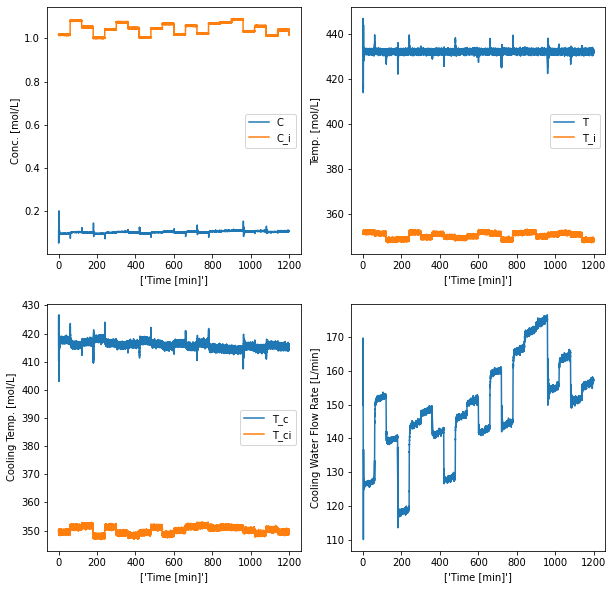

In [202]:
plt.subplots(2,2,figsize=(10,10))

ax=plt.subplot(2,2,1)
results[['C','C_i']].plot(ax=ax)
plt.ylabel('Conc. [mol/L]')
plt.xlabel(['Time [min]'])


ax=plt.subplot(2,2,2)
results[['T','T_i']].plot(ax=ax)
plt.ylabel('Temp. [mol/L]')
plt.xlabel(['Time [min]'])


ax=plt.subplot(2,2,3)
results[['T_c','T_ci']].plot(ax=ax)
plt.ylabel('Cooling Temp. [mol/L]')
plt.xlabel(['Time [min]'])


ax=plt.subplot(2,2,4)
results["Q_c"].plot(ax=ax)
plt.ylabel('Cooling Water Flow Rate [L/min]')
plt.xlabel(['Time [min]'])

plt.savefig(path/"dataset_substandard_all_sample.png", dpi=100)


# Dataset Generation: Substandard Operation (all)

Generating a lot of data using the model above for 43200 minutes.

In [207]:
# Define the input parameters and PID controller
t_span = (0, 43200) # Start and end time
pid=PID(K_p=-1,tau_i=-0.5,setpoint=430,u_bias=150,limits=(20,200), sample_dt=0.01)
change_dt = 60 # How often inputs change
T_max =  43200 # time when there is a 10% reduction in catalyst and jacket 


# Define perturbed inputs (change every change_dt minutes)
size = int(t_span[1]/60)+1
C_i_list = np.random.uniform(size=size,low=0.9, high=1.0)
T_i_list = np.random.uniform(size=size,low=348, high=352)
T_ci_list = np.random.uniform(size=size,low=348, high=352)

# Solve equations
t_eval = np.linspace(t_span[0],t_span[1],num=int((t_span[1])*100))
y0 = [0.11, 440, 410]
res = solve_ivp(cstr_model_real,t_span,y0, method='RK45',max_step=0.01,t_eval=t_eval)


Results at final time step are:  [0.11, 429.73, 413.41, 177.36735260504943]


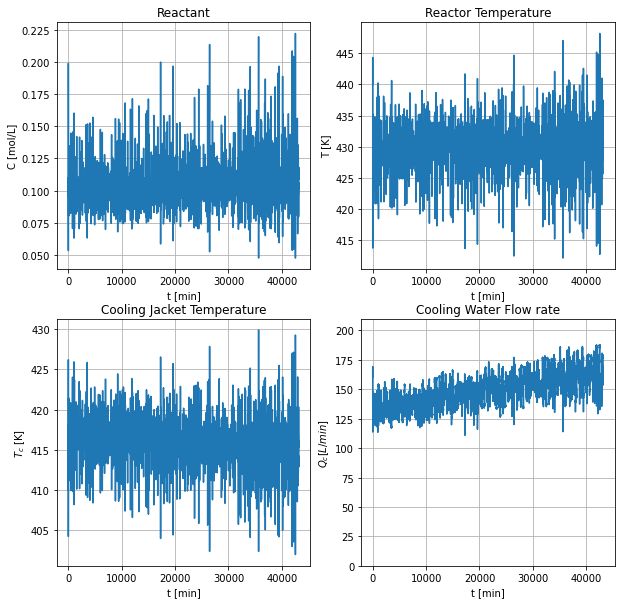

In [208]:
plot_results(res.t, res.y, pid)
#plt.savefig(path/"dataset_substandard.png", dpi=100)

In [209]:
# Dynamic variables
C = res.y[0]
T = res.y[1]
T_c = res.y[2]
t=res.t
tmp = pd.DataFrame([C,T,T_c],).T
tmp.columns = ['C','T','T_c']
tmp.index=t

# Inlet variables
tmp_2 = pd.DataFrame([C_i_list,T_i_list, T_ci_list]).T
tmp_2.index=np.linspace(t_span[0],t_span[1],size)
tmp_2.columns=['C_i','T_i','T_ci']
tmp_2 = tmp_2.reindex(t_eval,method='ffill')

# PID
x = [0]+[item[0] for item in pid.store]
y = [150]+[item[1] for item in pid.store]
tmp_3 = pd.Series(y,index=x,name='Q_c').reindex(t_eval,method='ffill')

# Concat
results = pd.concat([tmp,tmp_2,tmp_3],axis=1)

# Sensor drift: Shift T and C_i by a certain amount
results['T'] = results['T']+2
results['C_i']=results['C_i']+0.1

# Gaussian noise
for item in results.columns:
    mean_val = results[item].mean()
    results[item]=results[item]+np.random.normal(size=(len(results)),scale=0.001*mean_val)


results

,C,T,T_c,C_i,T_i,T_ci,Q_c
0.00,0.110029,441.724692,410.132471,1.035382,348.306187,350.707920,149.930357
0.01,0.104962,442.212958,418.012977,1.037030,349.173865,350.975761,160.418618
0.02,0.100180,443.061692,420.637192,1.036809,348.752200,350.688142,161.206827
0.03,0.095841,443.784239,423.242554,1.036153,348.171070,350.740020,160.977154
0.04,0.091397,443.944780,425.379529,1.036421,348.317329,350.736545,161.878635
...,...,...,...,...,...,...,...
43199.96,0.113250,431.530315,413.528405,1.087179,350.928796,348.475789,177.360017
43199.97,0.113588,432.396266,413.203604,1.087290,350.266270,349.290727,177.119609
43199.98,0.113606,432.220621,413.375710,1.089235,350.194622,349.207561,177.139795
43199.99,0.113650,432.170021,412.839902,1.087205,350.729371,348.933242,177.436816


In [210]:
results.to_csv('substandard_model_all.csv')